In [3]:
import pandas as pd
import numpy as np
import os.path as osp

from changeit3d.external_tools.sgf.loader import initialize_and_load_sgf
from changeit3d.in_out.basics import unpickle_data
from changeit3d.utils.visualization import visualize_point_clouds_3d_v2
from changeit3d.in_out.pointcloud import pc_loader_from_npz

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## Assumes you have download ShapeTalk and our pretrained weights (shape_latents) and you have put them under ../../data
path_to_shapetalk = '../../data/shapetalk/language/shapetalk_preprocessed_public_version_0.csv'
path_to_sgf_latents = '../../data/pretrained/shape_latents/sgf_latent_codes.pkl'
top_pc_dir = '../../data/shapetalk/point_clouds/scaled_to_align_rendering'
npc_points = 4096

In [12]:
df = pd.read_csv(path_to_shapetalk)
# relevant_shapes = set(df[(df.changeit_split == "test") & df.source_object_class.isin(['chair'])]['source_uid'])
relevant_shapes = set(df[(df.changeit_split == "test")]['source_uid'])
print('test shapes', len(relevant_shapes))

test shapes 2895


In [13]:
random_seed = 2022
gt_pcs = {x: pc_loader_from_npz(osp.join(top_pc_dir, x + ".npz"), 
                                n_samples=npc_points, 
                                random_seed=random_seed) for x in relevant_shapes}

In [14]:
sgf_latents = next(unpickle_data(path_to_sgf_latents))

# pick a random sub-sample of latents to decode.
subsample = False
if subsample:
    n_shapes = 100
    np.random.seed(2023)
    uids = np.random.choice(list(relevant_shapes), n_shapes, replace=False)
else:
    uids = relevant_shapes
    
sgf_input = {uid: sgf_latents[uid] for uid in uids}

In [15]:
# Load SGF backbone 
import torch
import os
from tqdm.notebook import tqdm as tqdm
sgf = initialize_and_load_sgf()

# Run Inference
_, sgf_pcs = \
    sgf.eval_z(sgf_input, npc_points=npc_points, compute_mesh=False, save_output=False, skip_existing=False, output_dir='./sgf_out', return_results=True)

  0%|          | 0/2895 [00:00<?, ?it/s]

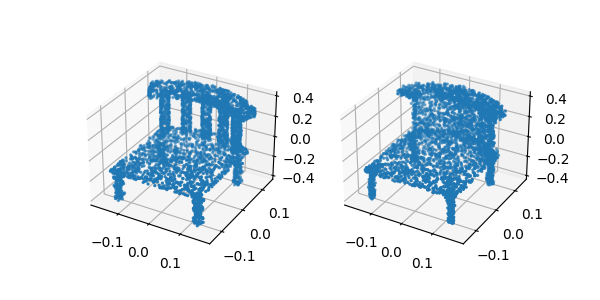

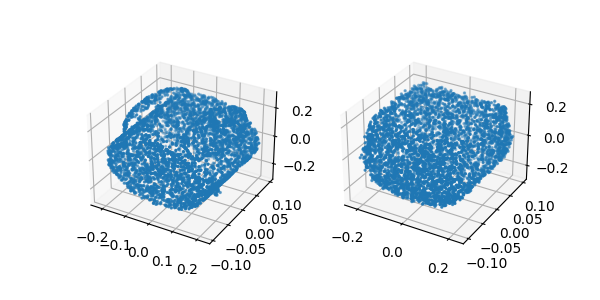

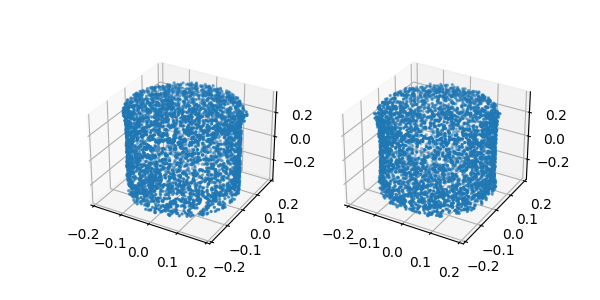

In [16]:
# Visualize
for n, uid in enumerate(uids):
    display(visualize_point_clouds_3d_v2([gt_pcs[uid], sgf_pcs[uid]]))
    if n > 1:
        break

In [17]:
# optionally, measure reconstruction error of SGF vs. GT
from changeit3d.evaluation.generic_metrics import chamfer_dists

all_gt = [] 
all_recon = []
for model_uid in sgf_pcs.keys():
     all_gt.append(gt_pcs[model_uid])
     all_recon.append(sgf_pcs[model_uid])     
all_gt = np.array(all_gt)
all_recon = np.array(all_recon)

print('Average Recon Error (Chamfer):', chamfer_dists(all_gt, all_recon, 128)[0])

Average Recon Error (Chamfer): 0.00013723336451221257
